## Model Setup Overview
The first cell prepares the runtime for evaluating the DeBERTa-v3-large cross-encoder.  I trained the model to classify directional course relationships.

It configures project paths, confirms CUDA and GPU availability on the DGX Sparx unit, and lists available fine-tuned checkpoints under the models/fine_tuned/ directory.

This initialization step ensures that subsequent cells (responsible for loading the tokenizer, model weights, and evaluation routines) run within a verified environment using the correct GPU-optimized configuration.

In [2]:
# Cell 1: Setup and Imports
import os
import json
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Union
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig
)

# Set up paths - notebook is in notebooks/ directory
ROOT = Path.cwd().parent  # Go up one level from notebooks/ to project root
MODEL_DIR = ROOT / "models" / "fine_tuned" / "deberta-v3-large-v1"  # Your successful model

# Verify paths exist
if not ROOT.exists():
    raise FileNotFoundError(f"Project root not found: {ROOT}")
if not MODEL_DIR.exists():
    raise FileNotFoundError(f"Model directory not found: {MODEL_DIR}")

print("🚀 Setting up Course Relationship Classifier")
print(f"Project root: {ROOT}")
print(f"Model directory: {MODEL_DIR}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# Show available models
models_dir = ROOT / "models" / "fine_tuned"
available_models = [d.name for d in models_dir.iterdir() if d.is_dir()]
print(f"📁 Available models: {available_models}")

🚀 Setting up Course Relationship Classifier
Project root: /home/craigtrim/projects/onto-rel-e5
Model directory: /home/craigtrim/projects/onto-rel-e5/models/fine_tuned/deberta-v3-large-v1
CUDA available: True
GPU: NVIDIA GB10
📁 Available models: ['deberta-v3-large', 'deberta-v3-large-v1']


## Model Loading and Inference Class Setup
The second cell defines and initializes the `CourseRelationshipClassifier`, a self-contained class for inference.

It loads the label mappings (`label2id.json`, `id2label.json`), retrieves the original tokenizer from the base microsoft/deberta-v3-large model, and automatically selects the most recent fine-tuned checkpoint.

The paragraph loads this model onto the active CUDA device in evaluation mode.

The class exposes `predict_single` for pairwise course comparison and `predict_batch` for bulk inference, returning both the predicted relationship label and full class probabilities for inspection

In [3]:
# Cell 2: Load Model and Tokenizer
class CourseRelationshipClassifier:
    def __init__(self, model_path: str):
        self.model_path = Path(model_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load label mappings
        with open(self.model_path / "label2id.json", "r") as f:
            self.label2id = json.load(f)
        with open(self.model_path / "id2label.json", "r") as f:
            self.id2label = {int(k): v for k, v in json.load(f).items()}
        
        # Load tokenizer from original model (doesn't change during fine-tuning)
        print("📦 Loading tokenizer...")
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
        
        # Find the best checkpoint directory
        checkpoint_dirs = [d for d in self.model_path.iterdir() if d.is_dir() and d.name.startswith("checkpoint-")]
        if not checkpoint_dirs:
            raise FileNotFoundError(f"No checkpoint directories found in {self.model_path}")
        
        # Use the highest numbered checkpoint (most recent)
        best_checkpoint = max(checkpoint_dirs, key=lambda x: int(x.name.split("-")[1]))
        print(f"🎯 Loading model from checkpoint: {best_checkpoint.name}")
        
        # Load model from the checkpoint directory
        print("🧠 Loading model...")
        self.model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint)
        self.model.to(self.device)
        self.model.eval()
        
        print(f"✅ Model loaded successfully!")
        print(f"📊 Classes: {list(self.label2id.keys())}")
    
    def predict_single(self, course_a: str, course_b: str) -> Dict:
        """Predict relationship between two courses"""
        # Tokenize
        inputs = self.tokenizer(
            course_a, 
            course_b,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )
        
        # Move to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Predict
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=-1)
        
        # Get prediction
        predicted_id = torch.argmax(probabilities, dim=-1).item()
        predicted_label = self.id2label[predicted_id]
        confidence = probabilities[0][predicted_id].item()
        
        # Get all probabilities
        all_probs = {
            self.id2label[i]: probabilities[0][i].item() 
            for i in range(len(self.id2label))
        }
        
        return {
            "course_a": course_a,
            "course_b": course_b,
            "predicted_relationship": predicted_label,
            "confidence": confidence,
            "all_probabilities": all_probs
        }
    
    def predict_batch(self, course_pairs: List[Tuple[str, str]]) -> List[Dict]:
        """Predict relationships for multiple course pairs"""
        results = []
        for course_a, course_b in course_pairs:
            result = self.predict_single(course_a, course_b)
            results.append(result)
        return results

# Initialize classifier
classifier = CourseRelationshipClassifier(MODEL_DIR)

📦 Loading tokenizer...


/home/craigtrim/miniconda3/envs/onto-rel-e5/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


🎯 Loading model from checkpoint: checkpoint-1130
🧠 Loading model...
✅ Model loaded successfully!
📊 Classes: ['A_is_subclass_of_B', 'B_is_subclass_of_A', 'equivalent', 'unrelated']


## Example Predictions and Sanity Check
The third cell runs a quick validation of the loaded model by passing several paired course titles through the classifier.

It prints each pair alongside the predicted relationship label and confidence score, allowing a fast qualitative check that the model and tokenizer are correctly aligned.

These test cases provide an immediate sanity check before integrating the classifier into a larger batch or evaluation workflow.

In [4]:
# Cell 3: Simple Examples
print("🎯 Simple Predictions\n" + "="*50)

# Test cases
test_cases = [
    ("Introduction to Psychology", "Psychology Fundamentals"),
    ("Advanced Calculus", "Basic Psychology"), 
    ("Computer Science", "Programming Fundamentals"),
    ("Organic Chemistry", "Music Theory"),
    ("Machine Learning", "Artificial Intelligence"),
    ("Linear Algebra", "Mathematics"),
    ("Web Development", "JavaScript Programming"),
    ("Psychology 101", "Introduction to Psychology"),
    ("Database Design", "Computer Science"),
    ("Creative Writing", "English Literature")
]

for course_a, course_b in test_cases:
    result = classifier.predict_single(course_a, course_b)
    print(f"Course A: {course_a}")
    print(f"Course B: {course_b}")
    print(f"Relationship: {result['predicted_relationship']}")
    print(f"Confidence: {result['confidence']:.1%}")
    print("-" * 30)

🎯 Simple Predictions
Course A: Introduction to Psychology
Course B: Psychology Fundamentals
Relationship: equivalent
Confidence: 99.1%
------------------------------
Course A: Advanced Calculus
Course B: Basic Psychology
Relationship: unrelated
Confidence: 99.9%
------------------------------
Course A: Computer Science
Course B: Programming Fundamentals
Relationship: B_is_subclass_of_A
Confidence: 100.0%
------------------------------
Course A: Organic Chemistry
Course B: Music Theory
Relationship: unrelated
Confidence: 99.9%
------------------------------
Course A: Machine Learning
Course B: Artificial Intelligence
Relationship: unrelated
Confidence: 99.7%
------------------------------
Course A: Linear Algebra
Course B: Mathematics
Relationship: A_is_subclass_of_B
Confidence: 99.8%
------------------------------
Course A: Web Development
Course B: JavaScript Programming
Relationship: B_is_subclass_of_A
Confidence: 94.0%
------------------------------
Course A: Psychology 101
Course B

📚 Course A: Government
📚 Course B: Civic Engagement
🎯 Predicted Relationship: B_is_subclass_of_A
🎲 Confidence: 83.4%

📊 All Probabilities:
  B_is_subclass_of_A  : 83.4%
  unrelated           : 13.3%
  A_is_subclass_of_B  : 3.0%
  equivalent          : 0.3%


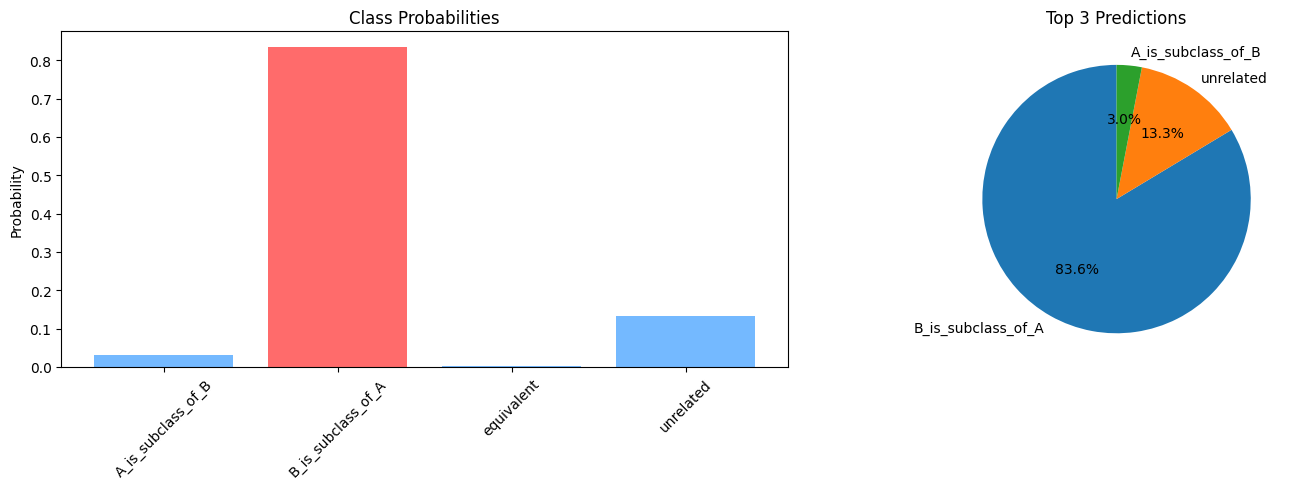

In [6]:
# Cell 4: Detailed Analysis Function
def analyze_relationship(course_a: str, course_b: str, show_plot: bool = True):
    """Detailed analysis with visualization"""
    result = classifier.predict_single(course_a, course_b)
    
    print(f"📚 Course A: {course_a}")
    print(f"📚 Course B: {course_b}")
    print(f"🎯 Predicted Relationship: {result['predicted_relationship']}")
    print(f"🎲 Confidence: {result['confidence']:.1%}")
    
    # Show all probabilities
    print(f"\n📊 All Probabilities:")
    for label, prob in sorted(result['all_probabilities'].items(), 
                             key=lambda x: x[1], reverse=True):
        print(f"  {label:20}: {prob:.1%}")
    
    if show_plot:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Bar plot of probabilities
        labels = list(result['all_probabilities'].keys())
        probs = list(result['all_probabilities'].values())
        colors = ['#ff6b6b' if label == result['predicted_relationship'] else '#74b9ff' 
                 for label in labels]
        
        ax1.bar(labels, probs, color=colors)
        ax1.set_title('Class Probabilities')
        ax1.set_ylabel('Probability')
        ax1.tick_params(axis='x', rotation=45)
        
        # Pie chart for top predictions
        top_probs = sorted(result['all_probabilities'].items(), 
                          key=lambda x: x[1], reverse=True)[:3]
        pie_labels = [item[0] for item in top_probs]
        pie_values = [item[1] for item in top_probs]
        
        ax2.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Top 3 Predictions')
        
        plt.tight_layout()
        plt.show()
    
    return result

# Example usage
result = analyze_relationship("Government", "Civic Engagement", show_plot=True)